In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import pysta
import stc
%load_ext autoreload
%autoreload 2

In [2]:
# load data

# load stim and spike data
# dataset_name = "20180618"
# dataset_name = "20180621"
dataset_name = "20180626"
#dataset_name = "20180828"

dataset_filename = "data/{}.mat".format(dataset_name)

stim, spike_train, info = pysta.load_data(dataset_filename)

channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]
# info["channel_names"]

# load cell type
cell_types = pd.read_csv("data/{}_cell_type.csv".format(dataset_name))
# cell_types

List of arrays in this file: 
 <KeysViewHDF5 ['#refs#', 'channel_names', 'height', 'sampling_rate', 'spike_train', 'stim', 'width']>
Shape of the array stim:  (64, 9000)
Shape of the array spike_train:  (156, 9000)
length of the list channel_names:  156
sampling_rate:  10.0


In [3]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": channel_names, "number_of_samples": num_samples})
# num_samples_df

In [4]:
# read eigenvalues

# helper function
def read_eigen_values(folder_name, channel_names):
    all_eig_values = dict()
    largest_eig_values = list()

    for channel_name in channel_names:
        filename = "{}/ch_{}_eig_val.txt".format(folder_name,channel_name)
        eig_val = np.loadtxt(filename)

        all_eig_values[channel_name] = eig_val
    #     eigen_values.append(eig_val)
        largest_eig_values.append(eig_val[0])
    return all_eig_values, largest_eig_values
    

#folder_name = "{}_stc_tap{}".format(dataset_name,tap)
folder_name = "{}_stc_tap{}_smoothed".format(dataset_name,tap)

all_eig_values, largest_eig_values = read_eigen_values(folder_name, channel_names)

# convert to DataFrame
result_eig_smoothed = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})

Text(0, 0.5, 'count')

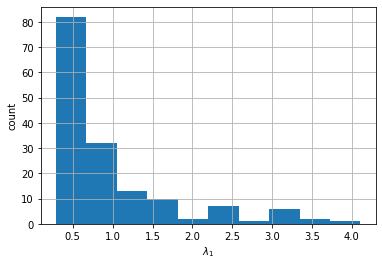

In [5]:
result_eig_smoothed["largest_eig_values"].hist()
plt.xlabel("$\lambda_1$")
plt.ylabel("count")

Text(0, 0.5, '$\\lambda_1$')

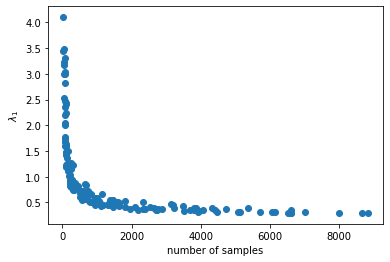

In [6]:
# merge with num_samples
num_samples_eig_smoothed = num_samples_df.merge(result_eig_smoothed)

plt.scatter(num_samples_eig_smoothed["number_of_samples"], num_samples_eig_smoothed["largest_eig_values"])
plt.xlabel('number of samples')
#plt.ylabel('largest eigenvalue')
plt.ylabel('$\lambda_1$')
# plt.yscale('log')
# plt.xscale('log')

# see https://arxiv.org/pdf/0901.3245.pdf to understand the effect of # samples on the largest eigenvalue
    